### EXP: kappa and dice for all experts raters

In [1]:
import os
import pandas as pd
import numpy as np
import json
import itertools
import seaborn as sns
from sklearn import metrics
from matplotlib import gridspec as gs
import matplotlib.pyplot as plt
from functools import reduce

In [2]:
%matplotlib inline
%load_ext rpy2.ipython
sns.set(style="white")

In [3]:
def CustomParser(data):
    j1 = json.loads(data)
    return j1

In [4]:
# Read raw table
classifications = pd.read_csv('../data/rating/brain-match-classifications-12-10-2018.csv', 
                              converters={'metadata':CustomParser,
                                          'annotations':CustomParser,
                                          'subject_data':CustomParser},
                              header=0)

In [5]:
# List all workflows 
classifications.workflow_name.unique()

array(['Spot anatomical differences', 'Spot functional differences',
       'anat_internal_rating_pierre', 'anat_internal_rating_yassine',
       'Training Session', 'Basile', 'Benjamin', 'Maxime', 'Angela',
       'Sara', 'Pierre_func_rate_1', 'Pierre_anat_rate1',
       'Yassine_func_rate_1', 'Pierre_func_rate_2', 'Start Project',
       'Start Project 1', 'Expert Project 1', 'Expert Project 2',
       'Start Project 2'], dtype=object)

In [6]:
# Get 3 experts from full launch workflow
ratings_sp1 =  classifications.loc[classifications['workflow_name'].isin(['Start Project 1'])]
ratings_sp1 = ratings_sp1[ratings_sp1.user_name.isin([ 'colezweber','ppf'])]
# Get rating from first expert workflow
ratings_ep1 = classifications.loc[classifications['workflow_name'].isin(['Expert Project 1'])]
ratings_ep1 = ratings_ep1[ratings_ep1.user_name.isin(['angelatam', 'jenichen', 'ppf','abadhwar'])]
ratings = ratings_sp1.append(ratings_ep1)
# Get rating from second expert workflow
ratings_ep2 = classifications.loc[classifications['workflow_name'].isin(['Expert Project 2'])]
ratings = ratings.append(ratings_ep2)
ratings.count()

classification_id    1247
user_name            1247
user_id              1247
user_ip              1247
workflow_id          1247
workflow_name        1247
workflow_version     1247
created_at           1247
gold_standard           0
expert                  0
metadata             1247
annotations          1247
subject_data         1247
subject_ids          1247
dtype: int64

In [7]:
# extract tagging count
ratings.loc[:,"n_tagging"] = [ len(q[0]['value']) for q in ratings.annotations]
# extract rating count
ratings.loc[:,"rating"] = [ q[1]['value'] for q in ratings.annotations]
# extract subjects id
ratings.loc[:,"ID"] = [ row.subject_data[str(ratings.subject_ids.loc[ind])]['subject_ID'] for ind,row in ratings.iterrows()]
# extract files name
ratings.loc[:,"imgnm"] = [ row.subject_data[str(ratings.subject_ids.loc[ind])]['image1'] for ind,row in ratings.iterrows()]

In [8]:
# Remove non-experts
ratings = ratings[~ratings.user_name.isin(['crocodoyle',
                                           'alinanaseer',
                                           'EloiPrevost',
                                           'venguix',
                                           'ashherr17'])]

In [9]:
# How many rating per user
user_count = ratings.user_name.value_counts()
user_count

ppf           213
colezweber    149
surchs        105
emdupre       102
paulej        102
cmakowski     102
angelatam     101
abadhwar      100
jenichen      100
Name: user_name, dtype: int64

In [10]:
#select only users that have rated a certain ammount of images 
list_user = user_count.index
list_user = list_user[user_count.values>=10]
user_count[list_user]

ppf           213
colezweber    149
surchs        105
emdupre       102
paulej        102
cmakowski     102
angelatam     101
abadhwar      100
jenichen      100
Name: user_name, dtype: int64

In [11]:
# remove users with less rating then the selected threshold
ratings = ratings[ratings.user_name.isin(list_user)]
ratings.count()

classification_id    1074
user_name            1074
user_id              1074
user_ip              1074
workflow_id          1074
workflow_name        1074
workflow_version     1074
created_at           1074
gold_standard           0
expert                  0
metadata             1074
annotations          1074
subject_data         1074
subject_ids          1074
n_tagging            1074
rating               1074
ID                   1074
imgnm                1074
dtype: int64

In [12]:
# drop duplicated rating
inc = 0
sum_dup = 0
for ind,user in enumerate(ratings.user_name.unique()):
    user_select_df = ratings[ratings.user_name.isin([user])]
    mask=~user_select_df.ID.duplicated()
    dup = len([m for m in mask if m == False])
    sum_dup = sum_dup+ dup
    if dup > 0 :
        print('{} have {} duplicated ratings'.format(user,dup))
    if ind == 0 and inc == 0:
        classi_unique= user_select_df[mask]
        inc+=1
    else:
        classi_unique = classi_unique.append(user_select_df[~user_select_df.ID.duplicated()])
        inc+=1
print('Total number of duplicated ratings  = {}'.format(sum_dup))

colezweber have 49 duplicated ratings
ppf have 113 duplicated ratings
angelatam have 1 duplicated ratings
surchs have 5 duplicated ratings
emdupre have 2 duplicated ratings
cmakowski have 2 duplicated ratings
paulej have 2 duplicated ratings
Total number of duplicated ratings  = 174


In [13]:
# Get the final rating numbers per subject
user_count = classi_unique.user_name.value_counts()
user_count

ppf           100
abadhwar      100
emdupre       100
surchs        100
paulej        100
colezweber    100
jenichen      100
angelatam     100
cmakowski     100
Name: user_name, dtype: int64

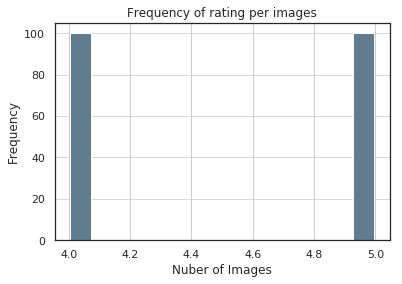

In [14]:
# plot rating per image distribution
image_count = classi_unique.subject_ids.value_counts()
image_count.plot.hist(grid=True,rwidth=0.9, bins=13,color='#607c8e')
plt.title('Frequency of rating per images')
plt.xlabel('Nuber of Images')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

In [15]:
#Create Users rating dataframe
list_user = user_count.index
concat_rating = [classi_unique[classi_unique.user_name == user][['ID','rating']].rename(columns={'rating': user})
                  for user in list_user]

df_ratings = reduce(lambda left,right: pd.merge(left,right,how='outer',on='ID'), concat_rating)
df_ratings.head()

,ID,ppf,abadhwar,emdupre,surchs,paulej,colezweber,jenichen,angelatam,cmakowski
0,X2081148,OK,OK,OK,OK,OK,OK,Maybe,OK,OK
1,X3917422,Fail,Fail,Maybe,Maybe,Maybe,Maybe,Maybe,Fail,OK
2,X4104523,Fail,Fail,Maybe,Maybe,Maybe,Maybe,Fail,Maybe,Maybe
3,X3163200,Maybe,OK,Maybe,Maybe,OK,OK,Maybe,Maybe,OK
4,X2297413,Fail,Fail,Fail,Fail,Fail,Fail,Fail,Fail,Fail


In [16]:
# remove duplicates
df_ratings = df_ratings[~df_ratings.ID.duplicated()]

### Explore the concensus of rating between images

In [17]:
# Get ratings from images rated more tan N different rates 
n = 4 # Minimun number of ratings per image
stuff = np.array([[row.ID,
                   np.sum(row[1:].values=='Fail'),
                   np.sum(row[1:].values=='Maybe'),
                   np.sum(row[1:].values=='OK')]  
                  for ind, row in df_ratings.iterrows() if np.sum([np.sum(row[1:-1].values=='Fail'),
                                                                 np.sum(row[1:-1].values=='Maybe'),
                                                                 np.sum(row[1:-1].values=='OK')]) >= n])
df_score = pd.DataFrame(data=stuff, columns=['ID','Fail', 'Maybe', 'OK'])
df_score.head()

,ID,Fail,Maybe,OK
0,X2081148,0,1,8
1,X3917422,3,5,1
2,X4104523,3,6,0
3,X3163200,0,5,4
4,X2297413,9,0,0


In [18]:
# Normalise table's row
df_score_tmp = df_score[['Fail','Maybe','OK']].astype('int')
nb_rating = df_score[['Fail','Maybe','OK']].astype('int').sum(axis="columns")
df_norm = pd.DataFrame( index=df_score.index,columns=['ID','Fail', 'Maybe', 'OK'])
for status in ['Fail','Maybe','OK']:
    for image in df_score.index:
        df_norm[status][image] = np.int(df_score[status][image])/nb_rating[image]
        df_norm['ID'][image] = df_score['ID'][image]
# get max value
max_value = [row.iloc[1:].get_values().max() for ind,row in df_norm.iterrows()]
df_norm.loc[:,'EconVal'] = max_value
# get concensus rating
s = ['Fail', 'Maybe', 'OK']
#max_rate = [row.iloc[1:].idxmax(axis=1) for ind,row in df_norm.iterrows()]
max_rate = [s[row[1:].values.argmax()] for rid, row in df_norm.iterrows()]
df_norm.loc[:,'Econ'] = max_rate
# merge with zcon
zcon_df = pd.read_csv('../data/rating/full_launch_zooniverse_consensus.csv')
df_norm = df_norm.merge(zcon_df,on= 'ID')
df_norm.head()

,ID,Fail,Maybe,OK,EconVal,Econ,ZconVal,Zcon
0,X2081148,0,0.111111,0.888889,0.888889,OK,0.680000,OK
1,X3917422,0.333333,0.555556,0.111111,0.555556,Maybe,0.500000,Maybe
2,X4104523,0.333333,0.666667,0,0.666667,Maybe,0.421053,Maybe
3,X3163200,0,0.555556,0.444444,0.555556,Maybe,0.391304,Maybe
4,X2297413,1,0,0,1.000000,Fail,0.884615,Fail


In [19]:
# Normalise table's row
df_score_tmp = df_score[['Fail','Maybe','OK']].astype('int')
nb_rating = df_score[['Fail','Maybe','OK']].astype('int').sum(axis="columns")
df_norm = pd.DataFrame( index=df_score.index,columns=['ID','Fail', 'Maybe', 'OK'])
for status in ['Fail','Maybe','OK']:
    for image in df_score.index:
        df_norm[status][image] = np.int(df_score[status][image])/nb_rating[image]
        df_norm['ID'][image] = df_score['ID'][image]
# get max value
max_value = [row.iloc[1:].get_values().max() for ind,row in df_norm.iterrows()]
df_norm.loc[:,'EconVal'] = max_value
# get concensus rating
s = ['Fail', 'Maybe', 'OK']
#max_rate = [row.iloc[1:].idxmax(axis=1) for ind,row in df_norm.iterrows()]
max_rate = [s[row[1:].values.argmax()] for rid, row in df_norm.iterrows()]
df_norm.loc[:,'Econ'] = max_rate
# merge with zcon
zcon_df = pd.read_csv('../data/rating/full_launch_zooniverse_consensus.csv')
df_norm = df_norm.merge(zcon_df,on= 'ID')
df_norm.head()

,ID,Fail,Maybe,OK,EconVal,Econ,ZconVal,Zcon
0,X2081148,0,0.111111,0.888889,0.888889,OK,0.680000,OK
1,X3917422,0.333333,0.555556,0.111111,0.555556,Maybe,0.500000,Maybe
2,X4104523,0.333333,0.666667,0,0.666667,Maybe,0.421053,Maybe
3,X3163200,0,0.555556,0.444444,0.555556,Maybe,0.391304,Maybe
4,X2297413,1,0,0,1.000000,Fail,0.884615,Fail


/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


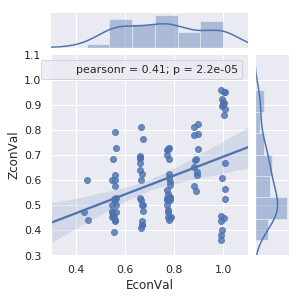

In [21]:
import scipy.stats as stats
sns.set(color_codes=True)
joint = sns.jointplot(x='EconVal', y='ZconVal',data= df_norm,
              kind="reg",xlim=[0.3,1.1], ylim=[0.3,1.1],x_jitter=.01)
joint.annotate(stats.pearsonr)

joint.fig.set_figwidth(4)
joint.fig.set_figheight(4)
plt.savefig('../reports/figures/Results/Kappa/expert_vs_zooniv_consensus.svg')

Text(0, 0.5, 'Concensus rating')

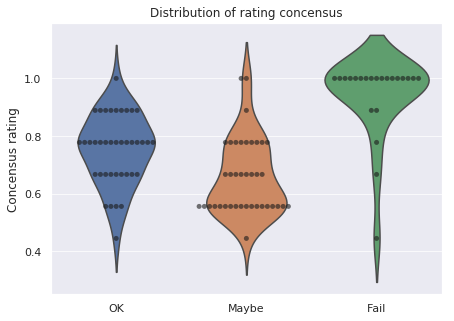

In [23]:
#Setting the figure with matplotlib
plt.figure(figsize=(7,5))
#plt.xticks(rotation=90)
plt.rcParams["axes.labelsize"] = 12
 
#Creating the desired plot
sns.violinplot(x='Econ',y='EconVal',data=df_norm,
              inner=None #removes the inner bars inside the violins 
              )
 
sns.swarmplot(x='Econ',y='EconVal',data=df_norm,
             color='k',#for making the points black
             alpha=0.6) #value of alpha will increase the transparency
 
#Title for the plot
plt.grid(axis='y', alpha=0.75)
plt.title('Distribution of rating concensus')
plt.xlabel('')
plt.ylabel('Concensus rating')

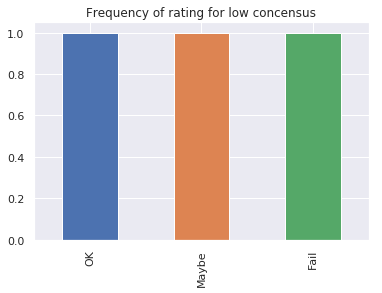

In [24]:
count_ = df_norm.Econ[[0 <= row.EconVal < 0.5   for ind, row in df_norm.iterrows() ]].value_counts()
axes = count_.plot.bar(title = 'Frequency of rating for low concensus')

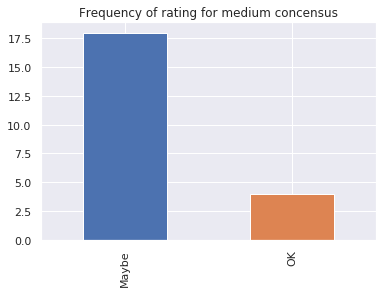

In [25]:
count_ = df_norm.Econ[[0.5 <= row.EconVal < 0.65   for ind, row in df_norm.iterrows() ]].value_counts()
axes = count_.plot.bar(title = 'Frequency of rating for medium concensus')

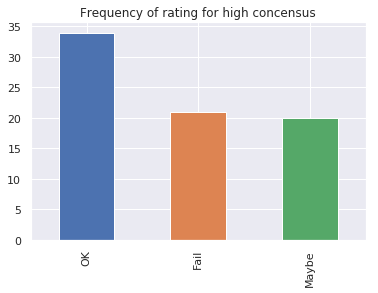

In [26]:
count_ = df_norm.Econ[[0.6 < row.EconVal <= 1   for ind, row in df_norm.iterrows() ]].value_counts()
axes = count_.plot.bar(title = 'Frequency of rating for high concensus')

In [27]:
# Save a copy
df_ratings.rename(columns={'angelatam':'R6',
                           'colezweber':'R9',
                           'ppf':'R8',
                           'jenichen':'R7',
                           'abadhwar':'R5',
                           'cmakowski':'R3',
                           'surchs':'R1',
                           'paulej':'R2',
                           'emdupre':'R4'},inplace=True)
df_ratings =df_ratings[['ID',
                        'R1',
                        'R2',
                        'R3',
                        'R4',
                        'R5',
                        'R6',
                        'R7',
                        'R8', 'R9']].merge(df_norm[['ID','Econ','Zcon','EconVal','ZconVal']],on='ID')
df_ratings.to_csv('../data/rating/all_experts_ratings.csv',index=False)
df_ratings.head()

,ID,R1,R2,R3,R4,R5,R6,R7,R8,R9,Econ,Zcon,EconVal,ZconVal
0,X2081148,OK,OK,OK,OK,OK,OK,Maybe,OK,OK,OK,OK,0.888889,0.680000
1,X3917422,Maybe,Maybe,OK,Maybe,Fail,Fail,Maybe,Fail,Maybe,Maybe,Maybe,0.555556,0.500000
2,X4104523,Maybe,Maybe,Maybe,Maybe,Fail,Maybe,Fail,Fail,Maybe,Maybe,Maybe,0.666667,0.421053
3,X3163200,Maybe,OK,OK,Maybe,OK,Maybe,Maybe,Maybe,OK,Maybe,Maybe,0.555556,0.391304
4,X2297413,Fail,Fail,Fail,Fail,Fail,Fail,Fail,Fail,Fail,Fail,Fail,1.000000,0.884615


In [25]:
# Save a copy
df_ratings.rename(columns={'angelatam':'R6',
                           'colezweber':'R9',
                           'ppf':'R8',
                           'jenichen':'R7',
                           'abadhwar':'R5',
                           'cmakowski':'R3',
                           'surchs':'R1',
                           'paulej':'R2',
                           'emdupre':'R4'},inplace=True)
df_ratings =df_ratings[['ID',
                        'R1',
                        'R2',
                        'R3',
                        'R4',
                        'R5',
                        'R6',
                        'R7',
                        'R8', 'R9']].merge(df_norm[['ID','Econ','Zcon','EconVal','ZconVal']],on='ID')
df_ratings.to_csv('../data/rating/all_experts_ratings.csv',index=False)
df_ratings.head()

,ID,R1,R2,R3,R4,R5,R6,R7,R8,R9,Econ,Zcon,EconVal,ZconVal
0,X2081148,OK,OK,OK,OK,OK,OK,Maybe,OK,OK,OK,OK,0.888889,0.680000
1,X3917422,Maybe,Maybe,OK,Maybe,Fail,Fail,Maybe,Fail,Maybe,Maybe,Maybe,0.555556,0.500000
2,X4104523,Maybe,Maybe,Maybe,Maybe,Fail,Maybe,Fail,Fail,Maybe,Maybe,Maybe,0.666667,0.421053
3,X3163200,Maybe,OK,OK,Maybe,OK,Maybe,Maybe,Maybe,OK,Maybe,Maybe,0.555556,0.391304
4,X2297413,Fail,Fail,Fail,Fail,Fail,Fail,Fail,Fail,Fail,Fail,Fail,1.000000,0.884615


In [26]:
# Randomly split raters in three groups
import random
random.seed(0)
myList= ['R1','R2','R3','R4','R5','R6','R7','R8','R9']
raters_split = [[myList.pop(random.randrange(len(myList))) for ii in range(3)] for ll in range(3)]

In [27]:
# Replace OK with 1 , Maybe with 2 and Fail with 3
df_ratings.replace({'OK':1,'Maybe':2, 'Fail':3}, inplace=True)

df_ratings.head()

,ID,R1,R2,R3,R4,R5,R6,R7,R8,R9,Econ,Zcon,EconVal,ZconVal
0,X2081148,1,1,1,1,1,1,2,1,1,1,1,0.888889,0.680000
1,X3917422,2,2,1,2,3,3,2,3,2,2,2,0.555556,0.500000
2,X4104523,2,2,2,2,3,2,3,3,2,2,2,0.666667,0.421053
3,X3163200,2,1,1,2,1,2,2,2,1,2,2,0.555556,0.391304
4,X2297413,3,3,3,3,3,3,3,3,3,3,3,1.000000,0.884615


In [28]:
%%R
suppressPackageStartupMessages(library(dplyr))
#install.packages("irr") 
library(irr)

/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: lpSolve

  warnings.warn(x, RRuntimeWarning)


In [29]:
# Percenteage of agrrement between raters with R package IRR
agree_ = df_ratings.drop(['ID','EconVal','Econ','Zcon','ZconVal'],axis=1)
%Rpush agree_
agree_n = %R agree(agree_)
print(agree_n)

 Percentage agreement (Tolerance=0)

 Subjects = 100 
   Raters = 9 
  %-agree = 20 



In [30]:
# FDR correction
from statsmodels.sandbox.stats import multicomp as smi

def fdr_transf(mat,log10 = False):
    '''compute fdr of a given matrix'''
    
    row = mat.shape[0]
    col = mat.shape[1]
    flatt = mat.flatten()
    fdr_2d = smi.multipletests(flatt, alpha=0.05, method='fdr_bh')[1]
    if log10 == True:
        fdr_2d = [-np.log10(ii) if ii != 0 else 50 for ii in fdr_2d  ]
    fdr_3d = np.reshape(fdr_2d,(row,col))
    return fdr_3d

In [31]:
# Kappa calculation
def kappa_score(k_df,log10 = False):
    '''compute Kappa between diferent raters organized in dataframe'''
    k_store = np.zeros((len(k_df.columns), len(k_df.columns)))
    p_store = np.zeros((len(k_df.columns), len(k_df.columns)))
    %Rpush k_df
    for user1_id, user1 in enumerate(k_df.columns):
        for user2_id, user2 in enumerate(k_df.columns):
            weight = np.unique(kappa_df[[user1,user2]])
            %Rpush user1_id user1 user2_id user2 weight
            kappaR =  %R kappa2(k_df[,c(user1,user2)],weight)
            
            # store the kappa
            k_store[user1_id, user2_id] = [kappaR[x][0] for x in range(np.shape(kappaR)[0])][4]
            p_store[user1_id, user2_id] = [kappaR[x][0] for x in range(np.shape(kappaR)[0])][-1]
            
    # FDR Correction       
    p_store = fdr_transf(p_store,log10)
    return k_store, p_store

In [32]:
# Get Kappa score out of all different combination of ratings
kappa_df  = df_ratings.drop(['ID','EconVal','ZconVal','Econ','Zcon'],axis=1)
kappa_store, Pval_store = kappa_score(kappa_df)
mean_kap = np.mean(kappa_store[np.triu_indices(len(kappa_store),k=1)])
std_kap = np.std(kappa_store[np.triu_indices(len(kappa_store),k=1)])
print('Mean Kappa : {0:.2f} , std : {1:.2f}\n'.format(mean_kap, std_kap))

#calculte the over all kappa values of all ratings
%Rpush kappa_df
fleiss_kappa = %R kappam.fleiss(kappa_df,c(0,1,2))
print(fleiss_kappa)

Mean Kappa : 0.54 , std : 0.08

 Fleiss' Kappa for m Raters

 Subjects = 100 
   Raters = 9 
    Kappa = 0.44 

        z = 37 
  p-value = 0 



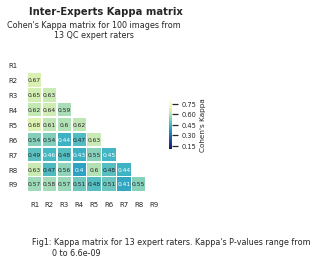

In [34]:
# Plot kappa matrix for expert only
kappa_out = pd.DataFrame(kappa_store, 
                         index=kappa_df.columns.get_values(),
                         columns=kappa_df.columns.get_values())


# Set up the matplotlib figure
f, axes = plt.subplots(figsize = (3,3))
f.subplots_adjust(hspace= .8)
sns.set(font_scale=0.6)
f.suptitle('Inter-Experts Kappa matrix',x=0.49,y=1.05, fontsize=10, fontweight='bold')
# Draw kappa heat map
mask = np.zeros_like(kappa_out)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(kappa_out,vmin=0.1,vmax=0.8,cmap="YlGnBu_r",
            square=True,
            annot=True,annot_kws={"size": 6},
            mask = mask,
            linewidths=.5, 
            cbar_kws={"shrink": .3,"label": "Cohen's Kappa"},  
            ax=axes)
sns.set(style="white")
sns.axes_style("white")

axes.set_yticks([x+0.5 for x in range(len(kappa_df.columns))])
axes.set_yticklabels(kappa_df.columns,rotation=0,fontsize=7)
axes.set_xticklabels(kappa_df.columns,rotation=0,fontsize=7)

text_title = '''
Cohen's Kappa matrix for {} images from
{} QC expert raters'''.format(len(df_ratings),len(df_ratings.columns[1:]))
axes.set_title(text_title,pad=20,fontsize=8)
#axes.annotate('Low', xy=(-0.17, 0.97),xytext=(-0.2, -0), xycoords='axes fraction',
              #arrowprops=dict(arrowstyle="fancy,tail_width=1.2,head_width=01",
                            #fc="0.7", ec="none",
                            #linewidth =2))

# Caption
pval = np.unique(Pval_store)[-1]
txt = '''
    Fig1: Kappa matrix for {} expert raters. Kappa's P-values range from
            {:.2g} to {:.2g} '''.format(len(df_ratings.columns[1:]),Pval_store.min(), Pval_store.max())
f.text(0.1,-0.1,txt,fontsize=8);
#f.text(0.11,0.88,'High',fontsize=12)
#f.text(0.10,0.62,'Level of QC expertise',fontsize=12,rotation=90)
# Save figure
f.savefig('../reports/figures/Results/Kappa/Full-Launch-experts_qc.svg')

In [35]:
from IPython.display import Image
Image(url= "https://i.stack.imgur.com/kYNd6.png" ,width=600, height=600)

### Boxplot of kappa distribution between raters

In [36]:
#compute kappa
kappa_df  = df_ratings.drop(['ID','EconVal','ZconVal','Econ','Zcon'],axis=1)
kappa_store, Pval_store = kappa_score(kappa_df)
# Get results into data frame
df_resul= pd.DataFrame(kappa_store,columns=kappa_df.columns,index=kappa_df.columns)
df_resul.head()

,R1,R2,R3,R4,R5,R6,R7,R8,R9
R1,1.000000,0.667570,0.651526,0.620563,0.675926,0.543646,0.490835,0.630485,0.574933
R2,0.667570,1.000000,0.634592,0.643221,0.614306,0.539506,0.458058,0.467603,0.582822
R3,0.651526,0.634592,1.000000,0.586777,0.598440,0.440820,0.479873,0.556213,0.568242
R4,0.620563,0.643221,0.586777,1.000000,0.615385,0.474606,0.433637,0.402174,0.513145
R5,0.675926,0.614306,0.598440,0.615385,1.000000,0.627876,0.548657,0.600000,0.479889


In [37]:
# transform results from matrix like to column like  
df1 = df_resul.stack().reset_index()
#set column names
df1.columns = ['a','b','c']
#remove kappa for between the same rater ( kappa of 1)
df1 = df1[~(df1.a == df1.b)]
df1.head()

,a,b,c
1,R1,R2,0.667570
2,R1,R3,0.651526
3,R1,R4,0.620563
4,R1,R5,0.675926
5,R1,R6,0.543646


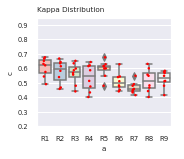

In [39]:
f, axes = plt.subplots(figsize = (2.4,2))
sns.set(style="white")
sns.axes_style("white")
sns.set(font_scale=0.6)
sns.boxplot(x='a', y='c', color="green", data=df1,palette="Pastel1",ax=axes)
sns.stripplot(x='a', y='c', data=df1, color="red", jitter=0.1, size=2.5,ax=axes)
axes.set_xticklabels(df1.a.unique(),rotation=0,fontsize=7)
axes.set_ylim([0.2,0.95])
plt.title("Kappa Distribution", loc="left")
plt.savefig('../reports/figures/Results/Kappa/expert_distrib.svg')

### Box plot of Kappa between expert and zooniverse consensus

In [40]:
# Get Kappa
kappa_df  = df_ratings.drop(['ID','EconVal','ZconVal'],axis=1)
kappa_store, Pval_store = kappa_score(kappa_df)
# transform results from matrix like to column like  
df= pd.DataFrame(kappa_store,columns=kappa_df.columns,index=kappa_df.columns)
df.head()

,R1,R2,R3,R4,R5,R6,R7,R8,R9,Econ,Zcon
R1,1.000000,0.667570,0.651526,0.620563,0.675926,0.543646,0.490835,0.630485,0.574933,0.817563,0.769585
R2,0.667570,1.000000,0.634592,0.643221,0.614306,0.539506,0.458058,0.467603,0.582822,0.801686,0.635569
R3,0.651526,0.634592,1.000000,0.586777,0.598440,0.440820,0.479873,0.556213,0.568242,0.735322,0.617408
R4,0.620563,0.643221,0.586777,1.000000,0.615385,0.474606,0.433637,0.402174,0.513145,0.726300,0.642602
R5,0.675926,0.614306,0.598440,0.615385,1.000000,0.627876,0.548657,0.600000,0.479889,0.756832,0.619289


In [41]:
# transform results from matrix like to column like  
df1 = df.stack().reset_index()
#set column names
df1.columns = ['a','b','c']
# slect only Zcon and Econ 
df2 = df1[((df1.b == 'Zcon') | (df1.b == 'Econ'))]
# remove kaa between the same rater
df3 = df2[~(df2.a == df2.b)]
# remove econ vs zcon kappa
df4 = df3[~((df1.a == 'Zcon') | (df1.a == 'Econ'))]
df4

/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


,a,b,c
9,R1,Econ,0.817563
10,R1,Zcon,0.769585
20,R2,Econ,0.801686
21,R2,Zcon,0.635569
31,R3,Econ,0.735322
32,R3,Zcon,0.617408
42,R4,Econ,0.726300
43,R4,Zcon,0.642602
53,R5,Econ,0.756832
54,R5,Zcon,0.619289


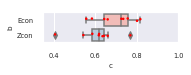

In [42]:
# box plot of zcon econ
f, axes = plt.subplots(figsize = (2.42,0.55))
sns.set(style="white")
sns.axes_style("white")
sns.set(font_scale=0.6)
sns.boxplot(x='c', y='b', color="green", data=df4, palette="Pastel1",ax=axes)
sns.stripplot(x='c', y='b', data=df4, color="red", jitter=0.1, size=2.5,ax=axes)
axes.set_xlim([0.35,1])
#axes.set_xticklabels(df4.b.unique(),rotation=90,fontsize=7)
plt.savefig('../reports/figures/Results/Kappa/expcon_vs_zooncon_distrib.svg')

### Kappa coef Zcon Econ

In [43]:
# Pivot table
df5=df4.pivot_table(values=['c'], index=['a'],columns=['b'])
# flaten hearers and rotate it 
df5.columns = df5.columns.levels[1].get_values()
df5.index.name = None
df5=df5.T
#df5 = df5[['Surc','Jpau','Cmak','Edup','Abad','Atam','Jche','Pfer', 'Czwe']]
df5

,R1,R2,R3,R4,R5,R6,R7,R8,R9
Econ,0.817563,0.801686,0.735322,0.726300,0.756832,0.643621,0.584583,0.557221,0.660359
Zcon,0.769585,0.635569,0.617408,0.642602,0.619289,0.543275,0.407245,0.586484,0.660524


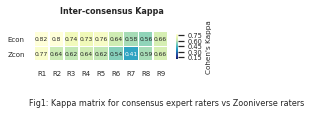

In [44]:
# Plot Dice matrix for concensus exert and  zooniverse

# Set up the matplotlib figure
f, axes = plt.subplots(figsize = (3,0.55))
f.subplots_adjust(hspace= .8)
sns.set(font_scale=0.6)
f.suptitle('Inter-consensus Kappa ',x=0.49,y=1.5, fontsize=8, fontweight='bold')
# Draw kappa heat map

sns.heatmap(df5,vmin=0.1,vmax=0.8,cmap="YlGnBu_r",
            square=True,
            annot=True,annot_kws={"size": 6},
            linewidths=.5, 
            cbar_kws={"shrink": 0.85,"label": "Cohen's Kappa"}, 
            ax=axes)
sns.set(style="white")
sns.axes_style("white")

#axes.set_yticks([x+0.5 for x in range(len(dice_df.columns))])
axes.set_yticklabels(df5.index,rotation=0,fontsize=7)
axes.set_xticklabels(df5.columns,rotation=0,fontsize=7)

# Caption
txt = '''
Fig1: Kappa matrix for consensus expert raters vs Zooniverse raters''';
f.text(0.1,-1,txt,fontsize=8);

# Save figure
f.savefig('../reports/figures/Results/Kappa/Full-Launch-consensus-experts-Vs-Zooniv.svg')

/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


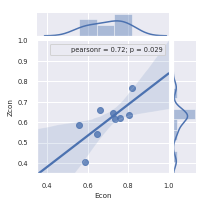

In [45]:
import scipy.stats as stats
sns.set(color_codes=True)
sns.set(font_scale=0.6)
joint = sns.jointplot(x='Econ', y='Zcon',data= df5.T,
              kind="reg",xlim=[0.35,1], ylim=[0.35,1])
joint.annotate(stats.pearsonr,)

joint.fig.set_figwidth(2.5)
joint.fig.set_figheight(2.5)
plt.savefig('../reports/figures/Results/Kappa/expert_vs_zooniv_consensus.svg')

### Compute Dice coefficient between raters 

In [46]:
def dice(im1, im2, empty_score=1.0):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        Both are empty (sum eq to zero) = empty_score
        
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum

In [49]:
# Dice matrix calculation
from sklearn.preprocessing import OneHotEncoder
def dice_score(d_df):
    '''calculate Dice coefficient between diferent raters organized in dataframe'''
    # initiate a one hot encoder
    onehot_encoder = OneHotEncoder(sparse=False)
    
    scales = np.unique(d_df)
    d_store = np.zeros((len(d_df.columns), len(d_df.columns),len(scales)))
    for ind_scal, scal in enumerate (scales):
        for user1_id, user1 in enumerate(d_df.columns):
            for user2_id, user2 in enumerate(d_df.columns):
                m1 = onehot_encoder.fit_transform(d_df[user1].values.reshape(len(d_df[user1]), 1))[:,ind_scal]
                m2 = onehot_encoder.fit_transform(d_df[user2].values.reshape(len(d_df[user2]), 1))[:,ind_scal]
                d_store[user1_id, user2_id,ind_scal] = dice(m1,m2)
    return d_store,scales

## Dice for OK category

In [50]:
# Get Kappa score out of all different combination of ratings
dice_df  = df_ratings.drop(['ID','EconVal','ZconVal','Econ','Zcon'],axis=1)
dice_store, scales = dice_score(dice_df)

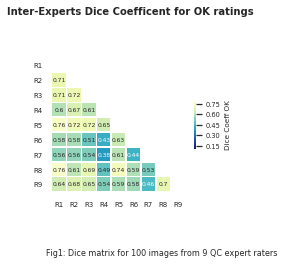

In [52]:
# Plot kappa matrix for expert only
dice_out = pd.DataFrame(dice_store[:,:,0], 
                         index=dice_df.columns.get_values(),
                         columns=dice_df.columns.get_values())


# Set up the matplotlib figure
f, axes = plt.subplots(figsize = (3,3))
f.subplots_adjust(hspace= .8)
sns.set(font_scale=0.6)
f.suptitle('Inter-Experts Dice Coefficent for OK ratings',x=0.49,y=1.05, fontsize=10, fontweight='bold')
# Draw kappa heat map
mask = np.zeros_like(dice_out)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dice_out,vmin=0.1,vmax=0.8,cmap="YlGnBu_r",
            square=True,
            annot=True,annot_kws={"size": 6},
            mask = mask,
            linewidths=.5, 
            cbar_kws={"shrink": .3,"label": "Dice Coeff OK"}, 
            ax=axes)
sns.set(style="white")
sns.axes_style("white")

axes.set_yticks([x+0.5 for x in range(len(dice_df.columns))])
axes.set_yticklabels(dice_df.columns,rotation=0,fontsize=7)
axes.set_xticklabels(dice_df.columns,rotation=0,fontsize=7)

# Caption
txt = '''
Fig1: Dice matrix for {} images from {} QC expert raters'''.format(len(dice_df),len(dice_df.columns));
f.text(0.1,-0.1,txt,fontsize=8);
#f.text(0.11,0.88,'High',fontsize=12)
#f.text(0.10,0.62,'Level of QC expertise',fontsize=12,rotation=90)
# Save figure
f.savefig('../reports/figures/Results/Dice/Full-Launch-experts_OK.svg')

### Boxplot of OK Dice distribution between raters

In [53]:
#compute Dice
dice_df  = df_ratings.drop(['ID','EconVal','ZconVal','Econ','Zcon'],axis=1)
dice_store, scales = dice_score(dice_df)
# Get results into data frame
df_resul= pd.DataFrame(dice_store[:,:,0],columns=dice_df.columns,index=dice_df.columns)
df_resul.head()

,R1,R2,R3,R4,R5,R6,R7,R8,R9
R1,1.000000,0.708861,0.705882,0.600000,0.758621,0.583333,0.558824,0.761905,0.643678
R2,0.708861,1.000000,0.717949,0.666667,0.725000,0.584615,0.557377,0.612245,0.675000
R3,0.705882,0.717949,1.000000,0.608696,0.720930,0.507042,0.537313,0.692308,0.651163
R4,0.600000,0.666667,0.608696,1.000000,0.647887,0.428571,0.384615,0.494382,0.535211
R5,0.758621,0.725000,0.720930,0.647887,1.000000,0.630137,0.608696,0.735849,0.590909


In [54]:
# transform results from matrix like to column like  
df1 = df_resul.stack().reset_index()
#set column names
df1.columns = ['a','b','c']
#remove kappa for between the same rater ( kappa of 1)
df1 = df1[~(df1.a == df1.b)]
df1.head()

,a,b,c
1,R1,R2,0.708861
2,R1,R3,0.705882
3,R1,R4,0.600000
4,R1,R5,0.758621
5,R1,R6,0.583333


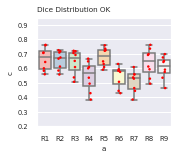

In [57]:
f, axes = plt.subplots(figsize = (2.4,2))
sns.set(style="white")
sns.axes_style("white")
sns.set(font_scale=0.6)
sns.boxplot(x='a', y='c', color="green", data=df1,palette="Pastel1")
sns.stripplot(x='a', y='c', data=df1, color="red", jitter=0.1, size=2.5)
axes.set_xticklabels(df1.a.unique(),rotation=0,fontsize=7)
axes.set_ylim([0.2,0.95])
plt.title("Dice Distribution OK", loc="left")
plt.savefig('../reports/figures/Results/Dice/expert_distrib_OK.svg')

### Box plot of OK Dice between expert and zooniverse consensus

In [58]:
# Get Dice
dice_df  = df_ratings.drop(['ID','EconVal','ZconVal'],axis=1)
dice_store, scales = dice_score(dice_df)
# transform results from matrix like to column like  
df= pd.DataFrame(dice_store[:,:,0],columns=dice_df.columns,index=dice_df.columns)
df.head()

,R1,R2,R3,R4,R5,R6,R7,R8,R9,Econ,Zcon
R1,1.000000,0.708861,0.705882,0.600000,0.758621,0.583333,0.558824,0.761905,0.643678,0.829268,0.826087
R2,0.708861,1.000000,0.717949,0.666667,0.725000,0.584615,0.557377,0.612245,0.675000,0.853333,0.729412
R3,0.705882,0.717949,1.000000,0.608696,0.720930,0.507042,0.537313,0.692308,0.651163,0.790123,0.725275
R4,0.600000,0.666667,0.608696,1.000000,0.647887,0.428571,0.384615,0.494382,0.535211,0.696970,0.684211
R5,0.758621,0.725000,0.720930,0.647887,1.000000,0.630137,0.608696,0.735849,0.590909,0.819277,0.752688


In [59]:
# transform results from matrix like to column like  
df1 = df.stack().reset_index()
#set column names
df1.columns = ['a','b','c']
# slect only Zcon and Econ 
df2 = df1[((df1.b == 'Zcon') | (df1.b == 'Econ'))]
# remove kaa between the same rater
df3 = df2[~(df2.a == df2.b)]
# remove econ vs zcon kappa
df4 = df3[~((df1.a == 'Zcon') | (df1.a == 'Econ'))]
df4

/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


,a,b,c
9,R1,Econ,0.829268
10,R1,Zcon,0.826087
20,R2,Econ,0.853333
21,R2,Zcon,0.729412
31,R3,Econ,0.790123
32,R3,Zcon,0.725275
42,R4,Econ,0.696970
43,R4,Zcon,0.684211
53,R5,Econ,0.819277
54,R5,Zcon,0.752688


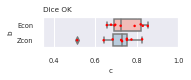

In [60]:
# box plot of zcon econ
f, axes = plt.subplots(figsize = (2.42,0.55))
sns.set(style="white")
sns.axes_style("white")
sns.set(font_scale=0.6)
sns.boxplot(x='c', y='b', color="green", data=df4, palette="Pastel1",ax=axes)
sns.stripplot(x='c', y='b', data=df4, color="red", jitter=0.1, size=2.5,ax=axes)
axes.set_xlim([0.35,1])
plt.title("Dice OK", loc="left")
plt.savefig('../reports/figures/Results/Dice/expcon_vs_zooncon_OK_distrib.svg')

### Dice coef Zcon Econ OK

In [61]:
# Pivot table
df5=df4.pivot_table(values=['c'], index=['a'],columns=['b'])
# flaten headers and rotate it 
df5.columns = df5.columns.levels[1].get_values()
df5.index.name = None
df5=df5.T
#df5 = df5[['Surc','Jpau','Cmak','Edup','Abad','Atam','Jche','Pfer', 'Czwe']]
df5

,R1,R2,R3,R4,R5,R6,R7,R8,R9
Econ,0.829268,0.853333,0.790123,0.696970,0.819277,0.676471,0.656250,0.693069,0.722892
Zcon,0.826087,0.729412,0.725275,0.684211,0.752688,0.641026,0.513514,0.774775,0.752688


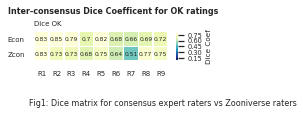

In [62]:
# Plot Dice matrix for concensus exert and  zooniverse

# Set up the matplotlib figure
f, axes = plt.subplots(figsize = (3,0.55))
f.subplots_adjust(hspace= .8)
sns.set(font_scale=0.6)
f.suptitle('Inter-consensus Dice Coefficent for OK ratings',x=0.49,y=1.5, fontsize=8, fontweight='bold')
# Draw kappa heat map
sns.set(font_scale=0.6)
sns.heatmap(df5,vmin=0.1,vmax=0.8,cmap="YlGnBu_r",
            square=True,
            annot=True,annot_kws={"size": 6},
            linewidths=.5, 
            cbar_kws={"shrink": .9,"label": "Dice Coef"}, 
            ax=axes)
sns.set(style="white")
sns.axes_style("white")

#axes.set_yticks([x+0.5 for x in range(len(dice_df.columns))])
axes.set_yticklabels(df5.index,rotation=0,fontsize=7)
axes.set_xticklabels(df5.columns,rotation=0,fontsize=7)

# Caption
txt = '''
Fig1: Dice matrix for consensus expert raters vs Zooniverse raters''';
f.text(0.1,-1,txt,fontsize=8);
plt.title("Dice OK", loc="left",fontsize=7)
# Save figure
f.savefig('../reports/figures/Results/Dice/Full-Launch-consensus-experts-Vs-Zooniv_OK.svg')

/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


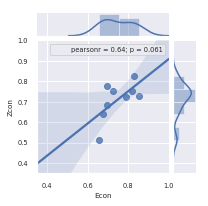

In [63]:
import scipy.stats as stats
sns.set(color_codes=True)
sns.set(font_scale=0.6)
joint = sns.jointplot(x='Econ', y='Zcon',data= df5.T,
              kind="reg",xlim=[0.35,1], ylim=[0.35,1])
joint.annotate(stats.pearsonr,)

joint.fig.set_figwidth(2.5)
joint.fig.set_figheight(2.5)
plt.savefig('../reports/figures/Results/Dice/expert_vs_zooniv_consensus_ok.svg')

## Dice for Maybe category

In [64]:
# Get Kappa score out of all different combination of ratings
dice_df  = df_ratings.drop(['ID','EconVal','ZconVal','Econ','Zcon'],axis=1)
dice_store, scales = dice_score(dice_df)

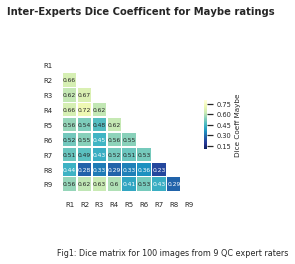

In [66]:
# Plot kappa matrix for expert only
dice_out = pd.DataFrame(dice_store[:,:,1], 
                         index=dice_df.columns.get_values(),
                         columns=dice_df.columns.get_values())


# Set up the matplotlib figure
f, axes = plt.subplots(figsize = (3,3))
f.subplots_adjust(hspace= .8)
sns.set(font_scale=0.6)
f.suptitle('Inter-Experts Dice Coefficent for Maybe ratings',x=0.49,y=1.05, fontsize=10, fontweight='bold')
# Draw kappa heat map
mask = np.zeros_like(dice_out)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dice_out,vmin=0.1,vmax=0.8,cmap="YlGnBu_r",
            square=True,
            annot=True,annot_kws={"size": 6},
            mask = mask,
            linewidths=.5, 
            cbar_kws={"shrink": .3,"label": "Dice Coeff Maybe"}, 
            ax=axes)
sns.set(style="white")
sns.axes_style("white")

axes.set_yticks([x+0.5 for x in range(len(dice_df.columns))])
axes.set_yticklabels(dice_df.columns,rotation=0,fontsize=7)
axes.set_xticklabels(dice_df.columns,rotation=0,fontsize=7)

# Caption
txt = '''
Fig1: Dice matrix for {} images from {} QC expert raters'''.format(len(dice_df),len(dice_df.columns));
f.text(0.1,-0.1,txt,fontsize=8);
#f.text(0.11,0.88,'High',fontsize=12)
#f.text(0.10,0.62,'Level of QC expertise',fontsize=12,rotation=90)
# Save figure
f.savefig('../reports/figures/Results/Dice/Full-Launch-experts_Maybe.svg')

### Boxplot of Maybe Dice distribution between raters

In [67]:
#compute Dice
dice_df  = df_ratings.drop(['ID','EconVal','ZconVal','Econ','Zcon'],axis=1)
dice_store, scales = dice_score(dice_df)
# Get results into data frame
df_resul= pd.DataFrame(dice_store[:,:,1],columns=dice_df.columns,index=dice_df.columns)
df_resul.head()

,R1,R2,R3,R4,R5,R6,R7,R8,R9
R1,1.000000,0.658228,0.619718,0.658824,0.562500,0.519481,0.506667,0.440000,0.563380
R2,0.658228,1.000000,0.666667,0.717391,0.535211,0.547619,0.487805,0.280702,0.615385
R3,0.619718,0.666667,1.000000,0.619048,0.476190,0.447368,0.432432,0.326531,0.628571
R4,0.658824,0.717391,0.619048,1.000000,0.623377,0.555556,0.522727,0.285714,0.595238
R5,0.562500,0.535211,0.476190,0.623377,1.000000,0.550725,0.507463,0.333333,0.412698


In [68]:
# transform results from matrix like to column like  
df1 = df_resul.stack().reset_index()
#set column names
df1.columns = ['a','b','c']
#remove kappa for between the same rater ( kappa of 1)
df1 = df1[~(df1.a == df1.b)]
df1.head()

,a,b,c
1,R1,R2,0.658228
2,R1,R3,0.619718
3,R1,R4,0.658824
4,R1,R5,0.562500
5,R1,R6,0.519481


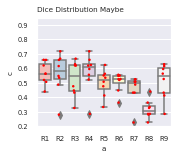

In [70]:
f, axes = plt.subplots(figsize = (2.4,2))
sns.set(style="white")
sns.axes_style("white")
sns.set(font_scale=0.6)
sns.boxplot(x='a', y='c', color="green", data=df1,palette="Pastel1")
sns.stripplot(x='a', y='c', data=df1, color="red", jitter=0.1, size=2.5)
axes.set_xticklabels(df1.a.unique(),rotation=0,fontsize=7)
axes.set_ylim([0.2,0.95])
plt.title("Dice Distribution Maybe", loc="left")
plt.savefig('../reports/figures/Results/Dice/expert_distrib_Maybe.svg')

### Box plot of Maybe Dice between expert and zooniverse consensus

In [71]:
# Get Dice
dice_df  = df_ratings.drop(['ID','EconVal','ZconVal'],axis=1)
dice_store, scales = dice_score(dice_df)
# transform results from matrix like to column like  
df= pd.DataFrame(dice_store[:,:,1],columns=dice_df.columns,index=dice_df.columns)
df.head()

,R1,R2,R3,R4,R5,R6,R7,R8,R9,Econ,Zcon
R1,1.000000,0.658228,0.619718,0.658824,0.562500,0.519481,0.506667,0.440000,0.563380,0.800000,0.776119
R2,0.658228,1.000000,0.666667,0.717391,0.535211,0.547619,0.487805,0.280702,0.615385,0.804878,0.675676
R3,0.619718,0.666667,1.000000,0.619048,0.476190,0.447368,0.432432,0.326531,0.628571,0.729730,0.636364
R4,0.658824,0.717391,0.619048,1.000000,0.623377,0.555556,0.522727,0.285714,0.595238,0.772727,0.650000
R5,0.562500,0.535211,0.476190,0.623377,1.000000,0.550725,0.507463,0.333333,0.412698,0.686567,0.508475


In [72]:
# transform results from matrix like to column like  
df1 = df.stack().reset_index()
#set column names
df1.columns = ['a','b','c']
# slect only Zcon and Econ 
df2 = df1[((df1.b == 'Zcon') | (df1.b == 'Econ'))]
# remove kaa between the same rater
df3 = df2[~(df2.a == df2.b)]
# remove econ vs zcon kappa
df4 = df3[~((df1.a == 'Zcon') | (df1.a == 'Econ'))]
df4

/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


,a,b,c
9,R1,Econ,0.800000
10,R1,Zcon,0.776119
20,R2,Econ,0.804878
21,R2,Zcon,0.675676
31,R3,Econ,0.729730
32,R3,Zcon,0.636364
42,R4,Econ,0.772727
43,R4,Zcon,0.650000
53,R5,Econ,0.686567
54,R5,Zcon,0.508475


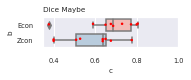

In [73]:
# box plot of zcon econ
f, axes = plt.subplots(figsize = (2.42,0.55))
sns.set(style="white")
sns.axes_style("white")
sns.set(font_scale=0.6)
sns.boxplot(x='c', y='b', color="green", data=df4, palette="Pastel1",ax=axes)
sns.stripplot(x='c', y='b', data=df4, color="red", jitter=0.1, size=2.5,ax=axes)
axes.set_xlim([0.35,1])
plt.title("Dice Maybe", loc="left")
plt.savefig('../reports/figures/Results/Dice/expcon_vs_zooncon_Maybe_distrib.svg')

### Dice coef Zcon Econ Maybe

In [74]:
# Pivot table
df5=df4.pivot_table(values=['c'], index=['a'],columns=['b'])
# flaten hearers and rotate it 
df5.columns = df5.columns.levels[1].get_values()
df5.index.name = None
df5=df5.T
#df5 = df5[['Surc','Jpau','Cmak','Edup','Abad','Atam','Jche','Pfer', 'Czwe']]
df5

,R1,R2,R3,R4,R5,R6,R7,R8,R9
Econ,0.800000,0.804878,0.729730,0.772727,0.686567,0.650000,0.589744,0.377358,0.675676
Zcon,0.776119,0.675676,0.636364,0.650000,0.508475,0.527778,0.400000,0.400000,0.636364


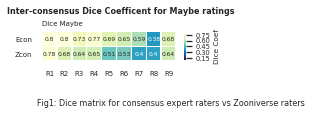

In [75]:
# Plot Dice matrix for concensus exert and  zooniverse

# Set up the matplotlib figure
f, axes = plt.subplots(figsize = (3,0.55))
f.subplots_adjust(hspace= .8)
sns.set(font_scale=0.6)
f.suptitle('Inter-consensus Dice Coefficent for Maybe ratings',x=0.49,y=1.5, fontsize=8, fontweight='bold')
# Draw kappa heat map
sns.set(font_scale=0.6)
sns.heatmap(df5,vmin=0.1,vmax=0.8,cmap="YlGnBu_r",
            square=True,
            annot=True,annot_kws={"size": 6},
            linewidths=.5, 
            cbar_kws={"shrink": .9,"label": "Dice Coef"}, 
            ax=axes)
sns.set(style="white")
sns.axes_style("white")

#axes.set_yticks([x+0.5 for x in range(len(dice_df.columns))])
axes.set_yticklabels(df5.index,rotation=0,fontsize=7)
axes.set_xticklabels(df5.columns,rotation=0,fontsize=7)

# Caption
txt = '''
Fig1: Dice matrix for consensus expert raters vs Zooniverse raters''';
f.text(0.1,-1,txt,fontsize=8);
plt.title("Dice Maybe", loc="left",fontsize=7)
# Save figure
f.savefig('../reports/figures/Results/Dice/Full-Launch-consensus-experts-Vs-Zooniv_Maybe.svg')

/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


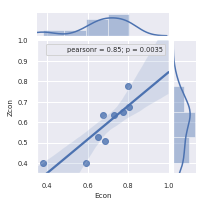

In [76]:
import scipy.stats as stats
sns.set(color_codes=True)
sns.set(font_scale=0.6)
joint = sns.jointplot(x='Econ', y='Zcon',data= df5.T,
              kind="reg",xlim=[0.35,1], ylim=[0.35,1])
joint.annotate(stats.pearsonr,)

joint.fig.set_figwidth(2.5)
joint.fig.set_figheight(2.5)
plt.savefig('../reports/figures/Results/Dice/expert_vs_zooniv_consensus_maybe.svg')

## Dice for Fail category

In [77]:
# Get Kappa score out of all different combination of ratings
dice_df  = df_ratings.drop(['ID','EconVal','ZconVal','Econ','Zcon'],axis=1)
dice_store, scales = dice_score(dice_df)

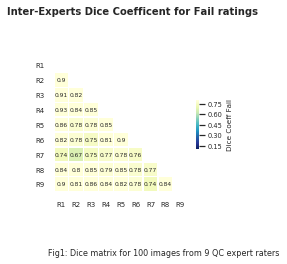

In [79]:
# Plot kappa matrix for expert only
dice_out = pd.DataFrame(dice_store[:,:,2], 
                         index=dice_df.columns.get_values(),
                         columns=dice_df.columns.get_values())


# Set up the matplotlib figure
f, axes = plt.subplots(figsize = (3,3))
f.subplots_adjust(hspace= .8)
sns.set(font_scale=0.6)
f.suptitle('Inter-Experts Dice Coefficent for Fail ratings',x=0.49,y=1.05, fontsize=10, fontweight='bold')
# Draw kappa heat map
mask = np.zeros_like(dice_out)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dice_out,vmin=0.1,vmax=0.8,cmap="YlGnBu_r",
            square=True,
            annot=True,annot_kws={"size": 6},
            mask = mask,
            linewidths=.5, 
            cbar_kws={"shrink": .3,"label": "Dice Coeff Fail"}, 
            ax=axes)
sns.set(style="white")
sns.axes_style("white")

axes.set_yticks([x+0.5 for x in range(len(dice_df.columns))])
axes.set_yticklabels(dice_df.columns,rotation=0,fontsize=7)
axes.set_xticklabels(dice_df.columns,rotation=0,fontsize=7)

# Caption
txt = '''
Fig1: Dice matrix for {} images from {} QC expert raters'''.format(len(dice_df),len(dice_df.columns));
f.text(0.1,-0.1,txt,fontsize=8);
#f.text(0.11,0.88,'High',fontsize=12)
#f.text(0.10,0.62,'Level of QC expertise',fontsize=12,rotation=90)
# Save figure
f.savefig('../reports/figures/Results/Dice/Full-Launch-experts_Fail.svg')

### Boxplot of Fail Dice distribution between raters

In [80]:
#compute Dice
dice_df  = df_ratings.drop(['ID','EconVal','ZconVal','Econ','Zcon'],axis=1)
dice_store, scales = dice_score(dice_df)
# Get results into data frame
df_resul= pd.DataFrame(dice_store[:,:,2],columns=dice_df.columns,index=dice_df.columns)
df_resul.head()

,R1,R2,R3,R4,R5,R6,R7,R8,R9
R1,1.000000,0.904762,0.909091,0.933333,0.857143,0.823529,0.736842,0.844444,0.904762
R2,0.904762,1.000000,0.818182,0.844444,0.775510,0.784314,0.666667,0.800000,0.809524
R3,0.909091,0.818182,1.000000,0.851064,0.784314,0.754717,0.745763,0.851064,0.863636
R4,0.933333,0.844444,0.851064,1.000000,0.846154,0.814815,0.766667,0.791667,0.844444
R5,0.857143,0.775510,0.784314,0.846154,1.000000,0.896552,0.781250,0.846154,0.816327


In [81]:
# transform results from matrix like to column like  
df1 = df_resul.stack().reset_index()
#set column names
df1.columns = ['a','b','c']
#remove kappa for between the same rater ( kappa of 1)
df1 = df1[~(df1.a == df1.b)]
df1.head()

,a,b,c
1,R1,R2,0.904762
2,R1,R3,0.909091
3,R1,R4,0.933333
4,R1,R5,0.857143
5,R1,R6,0.823529


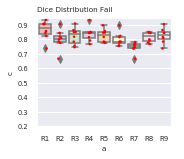

In [83]:
f, axes = plt.subplots(figsize = (2.4,2))
sns.set(style="white")
sns.axes_style("white")
sns.set(font_scale=0.6)
sns.boxplot(x='a', y='c', color="green", data=df1,palette="Pastel1")
sns.stripplot(x='a', y='c', data=df1, color="red", jitter=0.1, size=2.5)
axes.set_xticklabels(df1.a.unique(),rotation=0,fontsize=7)
axes.set_ylim([0.2,0.95])
plt.title("Dice Distribution Fail", loc="left")
plt.savefig('../reports/figures/Results/Dice/expert_distrib_Fail.svg')

### Box plot of Fail Dice between expert and zooniverse consensus

In [84]:
# Get Dice
dice_df  = df_ratings.drop(['ID','EconVal','ZconVal'],axis=1)
dice_store, scales = dice_score(dice_df)
# transform results from matrix like to column like  
df= pd.DataFrame(dice_store[:,:,2],columns=dice_df.columns,index=dice_df.columns)
df.head()

,R1,R2,R3,R4,R5,R6,R7,R8,R9,Econ,Zcon
R1,1.000000,0.904762,0.909091,0.933333,0.857143,0.823529,0.736842,0.844444,0.904762,0.976744,0.926829
R2,0.904762,1.000000,0.818182,0.844444,0.775510,0.784314,0.666667,0.800000,0.809524,0.883721,0.829268
R3,0.909091,0.818182,1.000000,0.851064,0.784314,0.754717,0.745763,0.851064,0.863636,0.888889,0.837209
R4,0.933333,0.844444,0.851064,1.000000,0.846154,0.814815,0.766667,0.791667,0.844444,0.956522,0.863636
R5,0.857143,0.775510,0.784314,0.846154,1.000000,0.896552,0.781250,0.846154,0.816327,0.880000,0.791667


In [85]:
# transform results from matrix like to column like  
df1 = df.stack().reset_index()
#set column names
df1.columns = ['a','b','c']
# slect only Zcon and Econ 
df2 = df1[((df1.b == 'Zcon') | (df1.b == 'Econ'))]
# remove kaa between the same rater
df3 = df2[~(df2.a == df2.b)]
# remove econ vs zcon kappa
df4 = df3[~((df1.a == 'Zcon') | (df1.a == 'Econ'))]
df4

/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


,a,b,c
9,R1,Econ,0.976744
10,R1,Zcon,0.926829
20,R2,Econ,0.883721
21,R2,Zcon,0.829268
31,R3,Econ,0.888889
32,R3,Zcon,0.837209
42,R4,Econ,0.956522
43,R4,Zcon,0.863636
53,R5,Econ,0.880000
54,R5,Zcon,0.791667


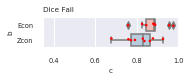

In [86]:
# box plot of zcon econ
f, axes = plt.subplots(figsize = (2.42,0.55))
sns.set(style="white")
sns.axes_style("white")
sns.set(font_scale=0.6)
sns.boxplot(x='c', y='b', color="green", data=df4, palette="Pastel1",ax=axes)
sns.stripplot(x='c', y='b', data=df4, color="red", jitter=0.1, size=2.5,ax=axes)
axes.set_xlim([0.35,1])
plt.title("Dice Fail", loc="left")
plt.savefig('../reports/figures/Results/Dice/expcon_vs_zooncon_Fail_distrib.svg')

### Dice coef Zcon Econ Fail

In [87]:
# Pivot table
df5=df4.pivot_table(values=['c'], index=['a'],columns=['b'])
# flaten hearers and rotate it 
df5.columns = df5.columns.levels[1].get_values()
df5.index.name = None
df5=df5.T
#df5 = df5[['Surc','Jpau','Cmak','Edup','Abad','Atam','Jche','Pfer', 'Czwe']]
df5

,R1,R2,R3,R4,R5,R6,R7,R8,R9
Econ,0.976744,0.883721,0.888889,0.956522,0.880000,0.846154,0.758621,0.826087,0.883721
Zcon,0.926829,0.829268,0.837209,0.863636,0.791667,0.760000,0.678571,0.772727,0.878049


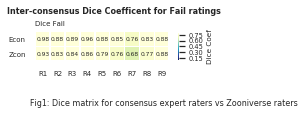

In [88]:
# Plot Dice matrix for concensus exert and  zooniverse

# Set up the matplotlib figure
f, axes = plt.subplots(figsize = (3,0.55))
f.subplots_adjust(hspace= .8)
sns.set(font_scale=0.6)
f.suptitle('Inter-consensus Dice Coefficent for Fail ratings',x=0.49,y=1.5, fontsize=8, fontweight='bold')
# Draw kappa heat map
sns.set(font_scale=0.6)
sns.heatmap(df5,vmin=0.1,vmax=0.8,cmap="YlGnBu_r",
            square=True,
            annot=True,annot_kws={"size": 6},
            linewidths=.5, 
            cbar_kws={"shrink": .9,"label": "Dice Coef"}, 
            ax=axes)
sns.set(style="white")
sns.axes_style("white")

#axes.set_yticks([x+0.5 for x in range(len(dice_df.columns))])
axes.set_yticklabels(df5.index,rotation=0,fontsize=7)
axes.set_xticklabels(df5.columns,rotation=0,fontsize=7)

# Caption
txt = '''
Fig1: Dice matrix for consensus expert raters vs Zooniverse raters''';
f.text(0.1,-1,txt,fontsize=8);
plt.title("Dice Fail", loc="left",fontsize=7)
# Save figure
f.savefig('../reports/figures/Results/Dice/Full-Launch-consensus-experts-Vs-Zooniv_Fail.svg')

/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


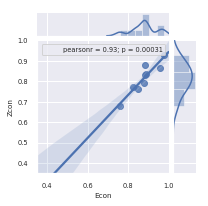

In [89]:
import scipy.stats as stats
sns.set(color_codes=True)
sns.set(font_scale=0.6)
joint = sns.jointplot(x='Econ', y='Zcon',data= df5.T,
              kind="reg",xlim=[0.35,1], ylim=[0.35,1])
joint.annotate(stats.pearsonr,)

joint.fig.set_figwidth(2.5)
joint.fig.set_figheight(2.5)
plt.savefig('../reports/figures/Results/Dice/expert_vs_zooniv_consensus_fail.svg')